In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

import os
import glob, time
import io
import random
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import Data

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving UNSWdata.tar.gz to UNSWdata.tar.gz
User uploaded file "UNSWdata.tar.gz" with length 122706982 bytes


In [0]:
'''
UNSWdata.tar.gz contains 4 tar.gz files: UNSW-NB15_*.tar.gz where * is 1 through 4.
Each UNSW-NB15_*.tar.gz contains a corresponding .csv file.
This was necessary because the original files are roughly 750MB, so loading directly
from .csv into a dataframe takes about an hour. With the tar.gz compression, this process
is cut down to about 10 minutes.
'''

# Extract from master tar.gz file
import tarfile
tf = tarfile.open(name='UNSWdata.tar.gz')
tf.extractall()

In [0]:
# Extract csv files from each tar.gz file
for i in range(1,5):
  tf = tarfile.open(name='UNSW-NB15_'+str(i)+'.tar.gz')
  tf.extractall()

In [5]:
# Read csv files into one dataframe

temp_list = []

for i in range(1,5):
    filename = 'UNSW-NB15_'+str(i)+'.csv'
    df = pd.read_csv(filename, index_col=None, header=None)
    temp_list.append(df)

data = pd.concat(temp_list, axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
from google.colab import files
start = time.time()
uploaded = files.upload()
end = time.time()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
print(end-start)

Saving UNSW-NB15_features.csv to UNSW-NB15_features.csv
User uploaded file "UNSW-NB15_features.csv" with length 4044 bytes
5.311690330505371


In [0]:
# getting feature names

feature_list = pd.read_csv('UNSW-NB15_features.csv',encoding='unicode_escape')
column_names = list(feature_list.Name)
data.columns = column_names

In [8]:
data.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0


In [9]:
data.shape

(2540047, 49)

In [10]:
print('Number of total attacks:',data.Label.sum(),'out of 2540047')
print('Percent attacks:',round(data.Label.mean(),2)*100,'%')

Number of total attacks: 321283 out of 2540047
Percent attacks: 13.0 %


#Data Cleaning

In [11]:

values={'attack_cat':'Normal'}
data.fillna(value=values,inplace=True) #NaNs in attack_cat is normal traffic
attack_dict = {k: v for v, k in enumerate(list(data.attack_cat.unique()))}  #encode each unique attack type with a value
data['attack_value'] = data['attack_cat'].map(attack_dict) 

#Drop unnecessary columns
data = data.drop(['srcip','sport','dstip','dsport','proto','service','state','Stime','Ltime'],axis=1)
data.columns = data.columns.str.lower()
data.sample(5)

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label,attack_value
152959,1.005937,1684,10168,31,29,3,5,1.243816e+04,76378.539060,14,18,255,255,1704329217,3850750683,120,565,0,0,8765.983829,7675.321479,77.352538,59.140765,0.000674,0.000540,0.000134,0,0,0.0,0.0,0,8,7,2,2,1,1,1,Normal,0,0
1517478,6.996241,922581,6182,62,252,349,8,1.053451e+06,7012.908691,706,124,255,255,1171454550,2095157475,1307,50,0,0,1256.035617,79.346852,9.923746,56.277488,0.119922,0.054245,0.065677,0,1,NaN,NaN,,1,1,1,1,1,1,1,Exploits,1,1
679613,0.001022,146,178,31,29,0,0,5.714286e+05,696673.187500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,0.008000,0.008000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,4,2,1,3,2,1,1,Normal,0,0
42885,0.004741,568,304,31,29,0,0,7.188357e+05,384728.968800,4,4,0,0,0,0,142,76,0,0,1.743963,1.516980,1.239667,1.079667,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,5,10,7,5,1,1,3,Normal,0,0
2520527,0.000009,264,0,60,0,0,0,1.173333e+08,0.000000,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,23,23,18,18,18,18,23,Normal,0,0


Cleaning the larger dataset has revealed two NaN heavy columns, 'ct_flw_http_mthd' and 'is_ftp_login'.  
**'is_ftp_login'** is supposed to be a binary that indicates whether the packets come from a user with an ftp login. However, there are a large amount of NaNs. There are also some values outside of 0 and 1 that aren't NaN, but there are a small amount of them.  
**'ct_flw_http_mthd'** according to the documentation:  
"*No. of flows that has methods such as Get and Post in http service.*"

In [12]:
nan_values = data.isna()
nan_columns = nan_values.any()

columns_with_nan = data.columns[nan_columns].tolist()
print(columns_with_nan)

['ct_flw_http_mthd', 'is_ftp_login']


In [13]:
data.is_ftp_login.isna().sum()

1429879

In [14]:
data.is_ftp_login.value_counts()

0.0    1066593
1.0      43389
4.0        156
2.0         30
Name: is_ftp_login, dtype: int64

In [15]:
print('ftp login True attacks: ',data[data['is_ftp_login'] == 1.0].label.sum(),'of 43389 =',round((data[data['is_ftp_login'] == 1.0].label.sum()/43389)*100,2),'%')
print('ftp login False attacks: ',data[data['is_ftp_login'] == 0.0].label.sum(),'of 1066593 =',round((data[data['is_ftp_login'] == 0.0].label.sum()/1066593)*100,2),'%')
print('ftp login NaN attacks: ',data[data['is_ftp_login'].isna()].label.sum(),'of 1429879 =',round((data[data['is_ftp_login'].isna()].label.sum()/1429879)*100,2),'%')

ftp login True attacks:  1909 of 43389 = 4.4 %
ftp login False attacks:  22167 of 1066593 = 2.08 %
ftp login NaN attacks:  297183 of 1429879 = 20.78 %


In [16]:
data.ct_flw_http_mthd.isna().sum()

1348145

In [17]:
data.ct_flw_http_mthd.value_counts()

0.0     986791
1.0     188008
6.0       7902
4.0       6564
3.0        738
2.0        588
5.0        430
9.0        270
14.0       224
12.0       132
30.0        60
8.0         56
16.0        48
36.0        36
10.0        30
25.0        25
Name: ct_flw_http_mthd, dtype: int64

In [18]:
print('ct flw http mthd NaN attacks: ',data[data['ct_flw_http_mthd'].isna()].label.sum(),'of 1348145 =',round((data[data['ct_flw_http_mthd'].isna()].label.sum()/1348145)*100,2),'%')
print('ct flw http mthd not NaN attacks: ',data[data['ct_flw_http_mthd'].notna()].label.sum(),'of 1191902 =',round((data[data['ct_flw_http_mthd'].notna()].label.sum()/1191902)*100,2),'%')

ct flw http mthd NaN attacks:  282939 of 1348145 = 20.99 %
ct flw http mthd not NaN attacks:  38344 of 1191902 = 3.22 %


In [0]:
data.is_ftp_login = data.is_ftp_login.fillna(value=100)
data.ct_flw_http_mthd = data.ct_flw_http_mthd.fillna(value=100)

I chose to fill the NaN values with 100 in each case. I don't want to drop them because they are information rich, and so I chose a base 10 positive integer that was well outside the range of the original values so that it would be easy to spot a NaN.

In [20]:
data.is_ftp_login.value_counts()

100.0    1429879
0.0      1066593
1.0        43389
4.0          156
2.0           30
Name: is_ftp_login, dtype: int64

In [21]:
data.ct_flw_http_mthd.value_counts()

100.0    1348145
0.0       986791
1.0       188008
6.0         7902
4.0         6564
3.0          738
2.0          588
5.0          430
9.0          270
14.0         224
12.0         132
30.0          60
8.0           56
16.0          48
36.0          36
10.0          30
25.0          25
Name: ct_flw_http_mthd, dtype: int64

In [0]:
data = data.drop(labels=['attack_cat','ct_ftp_cmd'],axis=1)

In [23]:
data.shape

(2540047, 39)

In [24]:
data.dtypes

dur                 float64
sbytes                int64
dbytes                int64
sttl                  int64
dttl                  int64
sloss                 int64
dloss                 int64
sload               float64
dload               float64
spkts                 int64
dpkts                 int64
swin                  int64
dwin                  int64
stcpb                 int64
dtcpb                 int64
smeansz               int64
dmeansz               int64
trans_depth           int64
res_bdy_len           int64
sjit                float64
djit                float64
sintpkt             float64
dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports       int64
ct_state_ttl          int64
ct_flw_http_mthd    float64
is_ftp_login        float64
ct_srv_src            int64
ct_srv_dst            int64
ct_dst_ltm            int64
ct_src_ ltm           int64
ct_src_dport_ltm      int64
ct_dst_sport_ltm    

In [0]:
data = data.astype('float64')
data['label'] = data['label'].astype('int64')
data['attack_value'] = data['attack_value'].astype('int64')

In [26]:
data.dtypes

dur                 float64
sbytes              float64
dbytes              float64
sttl                float64
dttl                float64
sloss               float64
dloss               float64
sload               float64
dload               float64
spkts               float64
dpkts               float64
swin                float64
dwin                float64
stcpb               float64
dtcpb               float64
smeansz             float64
dmeansz             float64
trans_depth         float64
res_bdy_len         float64
sjit                float64
djit                float64
sintpkt             float64
dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports     float64
ct_state_ttl        float64
ct_flw_http_mthd    float64
is_ftp_login        float64
ct_srv_src          float64
ct_srv_dst          float64
ct_dst_ltm          float64
ct_src_ ltm         float64
ct_src_dport_ltm    float64
ct_dst_sport_ltm    

#Neural Network Preparation

In [0]:
#Creating a Dataset object for loading into PyTorch

class unswData_bin(Dataset):
      def __init__(self, data):
          self.features = data[:,0:38]
          self.labels = data[:,-2]
      
      def __getitem__(self, index):
          return torch.tensor(self.features[index,:],dtype=torch.float), torch.tensor(self.labels[index],dtype=torch.long)
      
      def __len__(self):
          return self.features.shape[0]

class unswData_multi(Dataset):
      def __init__(self, data):
          self.features = data[:,0:38]
          self.labels = data[:,-1]
      
      def __getitem__(self, index):
          return torch.tensor(self.features[index,:],dtype=torch.float), torch.tensor(self.labels[index],dtype=torch.long)
      
      def __len__(self):
          return self.features.shape[0]

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/')

from mpdl import train_network, Flatten, View, weight_reset

In [0]:
train_len = int(len(data)*0.6)
test_len = int(len(data)*0.2)
val_len = int(len(data)-train_len-test_len)
unsw_data = unswData_bin(data.values)

train_data, test_data, val_data = torch.utils.data.random_split(unsw_data, [train_len, test_len, val_len])

In [0]:
train_load = DataLoader(train_data,batch_size=128)
test_load = DataLoader(test_data,batch_size=128)
val_load = DataLoader(val_data,batch_size=128)

#First Model

Linear

In [0]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 38
#Hidden layer size
n = 10 
#How many classes are there?
classes = 2

loss_func = nn.CrossEntropyLoss()

In [0]:
binary_model = nn.Sequential(
    nn.Linear(D,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n, classes),
)

In [0]:
binary_results = train_network(binary_model,loss_func=loss_func,train_loader=train_load,val_loader=test_load,
                               score_funcs = {'Accuracy:':accuracy_score},epochs=10,device=device,optimizer = torch.optim.SGD(binary_model.parameters(), lr=0.001))

In [0]:
binary_results

,epoch,total time,train loss,val loss,train Accuracy:,val Accuracy:
0,0,84.602510,480849.066440,480849.066440,0.866167,0.936084
1,1,168.705716,320292.441194,320292.441194,0.929043,0.933385
2,2,251.150464,283436.280580,283436.280580,0.931392,0.932661
3,3,333.708851,267625.936209,267625.936209,0.932552,0.932621
4,4,417.213054,258515.149714,258515.149714,0.933426,0.932377
5,5,501.046527,251190.169025,251190.169025,0.934808,0.937363
6,6,584.986880,245685.678070,245685.678070,0.935987,0.937231
7,7,667.942085,240742.548461,240742.548461,0.936922,0.937074
8,8,751.026570,237311.350040,237311.350040,0.937435,0.937727
9,9,834.697892,234666.166888,234666.166888,0.937825,0.938086


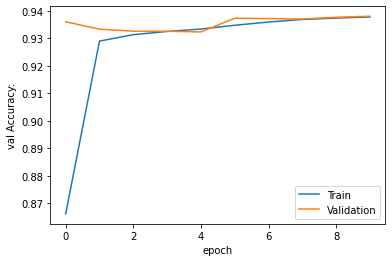

In [0]:
sns.lineplot(x='epoch', y='train Accuracy:', data=binary_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy:', data=binary_results, label='Validation')

#Optimizing with Optuna

In [0]:
!pip install optuna

     |████████████████████████████████| 163kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 49.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 112kB 52.0MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=698605c4b9dd72aaacf9cfc6242ba2c6c10ed17a0054101a81fec33151099997
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=0300d8a62c92d9a83742ed41732dbbbcf844a7ce6da185e5becc34446ef9caf4
  Stored in directory: /root/.cache/pip/wheels/62/

In [0]:
import optuna

In [0]:
#This code adapted from UMBC Data 690 lecture notes by Ed Raff.

def objective(trial):
    #Hidden layer size
    n = trial.suggest_int('neurons_per_layer', 8, 30) 
    layers = trial.suggest_int('hidden_layers', 5, 15) 

    #How many classes are there?
    classes = 2

    #At least one hidden layer, that take in D inputs
    sequential_layers = [
        nn.Linear(D,  n),
        nn.BatchNorm1d(n),
        nn.ReLU(),
    ]
    
    for _ in range(layers):
        sequential_layers.append( nn.Linear(n,  n) )
        sequential_layers.append( nn.BatchNorm1d(n))
        sequential_layers.append( nn.Sigmoid() )
    
    #Output layer
    sequential_layers.append( nn.Linear(n, classes) )
    

    binary_model = nn.Sequential(*sequential_layers)

    
    optimizer = torch.optim.SGD(binary_model.parameters(),lr=0.001)

    start = time.time()
    print('start', start, 'neurons', n,'hidden_layers',layers)
    results = train_network(binary_model, loss_func, train_load, val_loader=val_load,
                                     epochs=10, optimizer=optimizer,
                                     score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)
    end = time.time()
    print('runtime:',(end-start))
    return results['val Accuracy'].iloc[-1]  # A objective value linked with the Trial object.

In [0]:
study = optuna.create_study(direction='maximize')
start = time.time()
study.optimize(objective, n_trials=10)
end = time.time()
print('Total runtime:',(end-start))

start 1585774106.6227431 neurons 29 hidden_layers 14


[I 2020-04-01 21:16:41,088] Finished trial#0 resulted in value: 0.9398594515855987. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 1694.2402410507202
start 1585775801.0971024 neurons 18 hidden_layers 12


[I 2020-04-01 21:38:37,735] Finished trial#1 resulted in value: 0.9364992815102064. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 1316.3461740016937
start 1585777117.7455523 neurons 19 hidden_layers 14
runtime: 1458.3095903396606


[I 2020-04-01 22:02:56,278] Finished trial#2 resulted in value: 0.9345505009743903. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


start 1585778576.2892203 neurons 26 hidden_layers 5


[I 2020-04-01 22:18:57,574] Finished trial#3 resulted in value: 0.9362335387098679. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 961.0656318664551
start 1585779537.5819871 neurons 17 hidden_layers 9


[I 2020-04-01 22:35:18,785] Finished trial#4 resulted in value: 0.9348516761481073. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 981.0588140487671
start 1585780518.7916255 neurons 26 hidden_layers 7


[I 2020-04-01 22:51:41,463] Finished trial#5 resulted in value: 0.9344579831105687. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 982.5310888290405
start 1585781501.474048 neurons 8 hidden_layers 12


[I 2020-04-01 23:07:24,814] Finished trial#6 resulted in value: 0.9368063620794866. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 943.1725108623505
start 1585782444.823716 neurons 25 hidden_layers 14


[I 2020-04-01 23:31:06,081] Finished trial#7 resulted in value: 0.939138993326903. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 1421.1085863113403
start 1585783866.0890863 neurons 15 hidden_layers 6


[I 2020-04-01 23:44:32,240] Finished trial#8 resulted in value: 0.936367394342631. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 806.0068080425262
start 1585784672.249505 neurons 22 hidden_layers 13


[I 2020-04-02 00:06:12,032] Finished trial#9 resulted in value: 0.9361646424282987. Current best value is 0.9398594515855987 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}.


runtime: 1299.637279510498
Total runtime: 11865.428906202316


In [0]:
optuna.visualization.plot_contour(study)

In [0]:
optuna.visualization.plot_slice(study)

In [0]:
#This code adapted from UMBC Data 690 lecture notes by Ed Raff.

def objective(trial):
    #Hidden layer size
    n = trial.suggest_int('neurons_per_layer', 25, 40) 
    layers = trial.suggest_int('hidden_layers', 14, 25) 

    #How many classes are there?
    classes = 2

    #At least one hidden layer, that take in D inputs
    sequential_layers = [
        nn.Linear(D,  n),
        nn.BatchNorm1d(n),
        nn.ReLU(),
    ]
    
    for _ in range(layers):
        sequential_layers.append( nn.Linear(n,  n) )
        sequential_layers.append( nn.BatchNorm1d(n))
        sequential_layers.append( nn.Sigmoid() )
    
    #Output layer
    sequential_layers.append( nn.Linear(n, classes) )
    

    binary_model = nn.Sequential(*sequential_layers)

    
    optimizer = torch.optim.SGD(binary_model.parameters(),lr=0.001)

    start = time.time()
    print('start', start, 'neurons', n,'hidden_layers',layers)
    results = train_network(binary_model, loss_func, train_load, val_loader=val_load,
                                     epochs=10, optimizer=optimizer,
                                     score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)
    end = time.time()
    print('runtime:',(end-start))
    return results['val Accuracy'].iloc[-1]  # A objective value linked with the Trial object.

In [0]:
study = optuna.create_study(direction='maximize')
start = time.time()
study.optimize(objective, n_trials=10)
end = time.time()
print('Total runtime:',(end-start))

start 1585839000.1931233 neurons 28 hidden_layers 21


[I 2020-04-02 15:22:57,177] Finished trial#0 with value: 0.9387177417767367 with parameters: {'neurons_per_layer': 28, 'hidden_layers': 21}. Best is trial#0 with value: 0.9387177417767367.


runtime: 1976.8479704856873
start 1585840977.1863143 neurons 27 hidden_layers 15


[I 2020-04-02 15:49:25,963] Finished trial#1 with value: 0.9412137556347316 with parameters: {'neurons_per_layer': 27, 'hidden_layers': 15}. Best is trial#1 with value: 0.9412137556347316.


runtime: 1588.6452395915985
start 1585842565.9742024 neurons 26 hidden_layers 18


[I 2020-04-02 16:18:17,039] Finished trial#2 with value: 0.9389677368555737 with parameters: {'neurons_per_layer': 26, 'hidden_layers': 18}. Best is trial#1 with value: 0.9412137556347316.


runtime: 1730.9157085418701
start 1585844297.0499177 neurons 30 hidden_layers 20


[I 2020-04-02 16:51:41,338] Finished trial#3 with value: 0.940198027597882 with parameters: {'neurons_per_layer': 30, 'hidden_layers': 20}. Best is trial#1 with value: 0.9412137556347316.


runtime: 2004.1128628253937
start 1585846301.3493066 neurons 25 hidden_layers 18


[I 2020-04-02 17:20:06,729] Finished trial#4 with value: 0.9372925729808468 with parameters: {'neurons_per_layer': 25, 'hidden_layers': 18}. Best is trial#1 with value: 0.9412137556347316.


runtime: 1705.2435338497162
start 1585848006.7418275 neurons 40 hidden_layers 24
runtime: 2617.9871714115143


[I 2020-04-02 18:03:44,957] Finished trial#5 with value: 0.9370110824590067 with parameters: {'neurons_per_layer': 40, 'hidden_layers': 24}. Best is trial#1 with value: 0.9412137556347316.


start 1585850624.969426 neurons 36 hidden_layers 16


[I 2020-04-02 18:34:15,429] Finished trial#6 with value: 0.9396055195763863 with parameters: {'neurons_per_layer': 36, 'hidden_layers': 16}. Best is trial#1 with value: 0.9412137556347316.


runtime: 1830.3066520690918
start 1585852455.4387147 neurons 29 hidden_layers 14


[I 2020-04-02 18:59:50,983] Finished trial#7 with value: 0.9347414420975965 with parameters: {'neurons_per_layer': 29, 'hidden_layers': 14}. Best is trial#1 with value: 0.9412137556347316.


runtime: 1535.3917891979218
start 1585853990.995761 neurons 30 hidden_layers 18
runtime: 1827.2978775501251


[I 2020-04-02 19:30:18,627] Finished trial#8 with value: 0.9415995748115195 with parameters: {'neurons_per_layer': 30, 'hidden_layers': 18}. Best is trial#8 with value: 0.9415995748115195.


start 1585855818.6386 neurons 28 hidden_layers 19


[I 2020-04-02 20:01:11,438] Finished trial#9 with value: 0.9396547312060787 with parameters: {'neurons_per_layer': 28, 'hidden_layers': 19}. Best is trial#8 with value: 0.9415995748115195.


runtime: 1852.6594805717468
Total runtime: 18671.300325155258


In [0]:
optuna.visualization.plot_contour(study)

In [0]:
optuna.visualization.plot_slice(study)

#Optimized Network

In [0]:
n = 30

opt_model = nn.Sequential(
    nn.Linear(D,  n),
    nn.BatchNorm1d(n),
    nn.ReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.Sigmoid(),
    nn.Linear(n, classes),
)

In [43]:
opt_results = train_network(opt_model, loss_func, train_load, val_loader=test_load,
                                     epochs=10, optimizer=torch.optim.SGD(opt_model.parameters(),lr=0.001), checkpoint_file='opt_model.pt',
                                     score_funcs={'Accuracy': accuracy_score}, device=device)

In [44]:
opt_results

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,175.447893,326137.012640,326137.012640,0.916221,0.928633
1,1,355.524099,259231.089832,259231.089832,0.932280,0.928832
2,2,529.057877,247567.513162,247567.513162,0.933416,0.929121
3,3,702.222690,241339.994536,241339.994536,0.934088,0.929503
4,4,876.860093,237670.343283,237670.343283,0.934856,0.929852
5,5,1053.624207,234347.737697,234347.737697,0.935356,0.929468
6,6,1229.950118,231884.381342,231884.381342,0.935562,0.930090
7,7,1412.575907,230001.144473,230001.144473,0.935730,0.930377
8,8,1592.747093,228512.341641,228512.341641,0.935927,0.930688
9,9,1773.374820,227181.273002,227181.273002,0.936035,0.930578


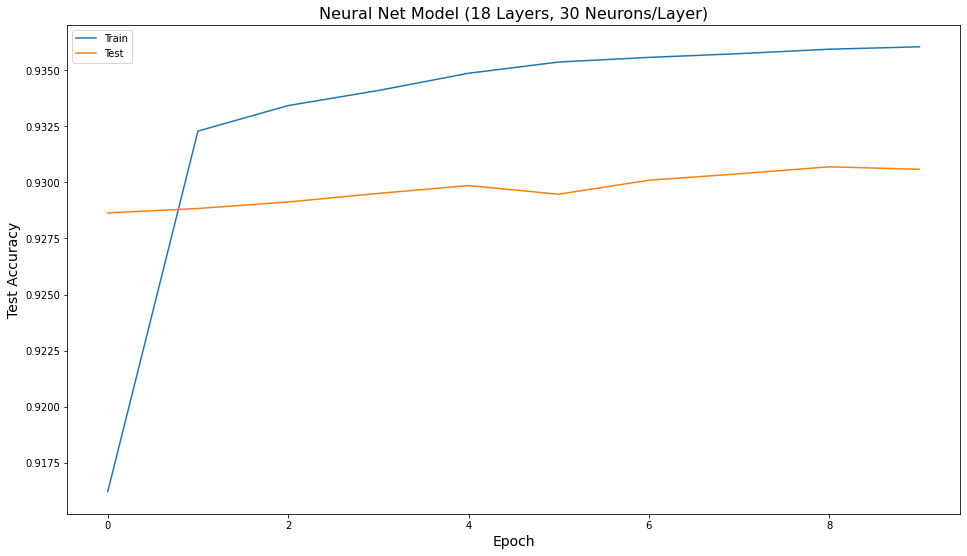

In [61]:
plt.figure(figsize=(16,9))
sns.lineplot(x='epoch', y='train Accuracy', data=opt_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=opt_results, label='Test')
plt.xlabel('Epoch',fontsize = 14)
plt.ylabel('Test Accuracy',fontsize = 14)
plt.title('Neural Net Model (18 Layers, 30 Neurons/Layer)',fontsize = 16)
#plt.savefig('NN_model.png',format='png')
#files.download('NN_model.png')

In [53]:
#Code adapted from UMBC Data 690 lecture notes

checkpoint_dict = torch.load('opt_model.pt', map_location=device)

model_new = opt_model
model_new.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [0]:
model = model_new.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
model = model.to(device)
y_true = []
y_pred = []
results = []
running_loss = 0.0


for inputs, labels in val_load:
        
  #Move the batch to the device we are using. 
  inputs = inputs.to(device)
  labels = labels.to(device)
        
  batch_size = inputs.shape[0]
  y_hat = model(inputs)
            
  loss = nn.CrossEntropyLoss()(y_hat, labels)
                
  #Now we are just grabbing some information we would like to have
  running_loss += loss.item() * inputs.size(0)

  #moving labels & predictions back to CPU for computing / storing predictions
  labels = labels.detach().cpu().numpy()
  y_hat = y_hat.detach().cpu().numpy()
  for i in range(batch_size):
      y_true.append(labels[i])
      y_pred.append(y_hat[i,:])
          
results.append( running_loss )

In [56]:
np.sum(np.array(y_true) == np.argmax(np.array(y_pred), axis=1))/float(len(y_true))

0.9306116021338162